<h1> Empirical estimation of IPMs (integral probability metrics)<span class="tocSkip"></span></h1>

Author: [Sylvain Combettes](https://github.com/sylvaincom).

Last update: Jan 29, 2020.

---
This notebook deals with the empirical estimation of IPMs (integral probability metrics) and completes my report on the _Comparison of empirical probability distributions_. As $f$-divergences work on probability distributions, IPMs work on samples drawn from the probability distributions.

<br/>

<div class="alert alert-info"><h4>README<span class="tocSkip"></span></h4><p>
The best way to open this Jupyter Notebook is to use the table of contents from the extensions called <code>nbextensions</code>. See <a href="https://towardsdatascience.com/4-awesome-tips-for-enhancing-jupyter-notebooks-4d8905f926c5">4 Awesome Tips for Enhancing Jupyter Notebooks</a> by George Seif.
    
The Python version is 3.7.3.
</p></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary:-Solving-a-linear-programming-problem-using-PuLP" data-toc-modified-id="Preliminary:-Solving-a-linear-programming-problem-using-PuLP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary: Solving a linear programming problem using <code>PuLP</code></a></span></li><li><span><a href="#Example-of-empirical-estimation-of-the-Kantorovich-metric-$W$" data-toc-modified-id="Example-of-empirical-estimation-of-the-Kantorovich-metric-$W$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example of empirical estimation of the Kantorovich metric $W$</a></span><ul class="toc-item"><li><span><a href="#Getting-the-canonical-form-of-the-linear-programming-problem" data-toc-modified-id="Getting-the-canonical-form-of-the-linear-programming-problem-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Getting the canonical form of the linear programming problem</a></span></li><li><span><a href="#Using-PuLP-to-solve-the-obtained-linear-programming-problem" data-toc-modified-id="Using-PuLP-to-solve-the-obtained-linear-programming-problem-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Using <code>PuLP</code> to solve the obtained linear programming problem</a></span></li></ul></li><li><span><a href="#Defining-a-generic-function-for-computing-the-estimate-of-the-Kantorovich-metric-$W$" data-toc-modified-id="Defining-a-generic-function-for-computing-the-estimate-of-the-Kantorovich-metric-$W$-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining a generic function for computing the estimate of the Kantorovich metric $W$</a></span><ul class="toc-item"><li><span><a href="#Defining-the-generic-function" data-toc-modified-id="Defining-the-generic-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Defining the generic function</a></span></li><li><span><a href="#The-memory-error-due-to-the-linear-programming-problem" data-toc-modified-id="The-memory-error-due-to-the-linear-programming-problem-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The memory error due to the linear programming problem</a></span></li></ul></li><li><span><a href="#Running-several-simulations-to-interpret-$W$" data-toc-modified-id="Running-several-simulations-to-interpret-$W$-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Running several simulations to interpret $W$</a></span><ul class="toc-item"><li><span><a href="#Comparing-two-normal-distributions" data-toc-modified-id="Comparing-two-normal-distributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Comparing two normal distributions</a></span><ul class="toc-item"><li><span><a href="#Influence-of-the-difference-of-means-$\mu_q-\mu_p$-on-$W$" data-toc-modified-id="Influence-of-the-difference-of-means-$\mu_q-\mu_p$-on-$W$-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Influence of the difference of means $\mu_q-\mu_p$ on $W$</a></span></li><li><span><a href="#Influence-of-the-difference-of-standard-deviations-$\sigma_q-\sigma_p$-on-$W$" data-toc-modified-id="Influence-of-the-difference-of-standard-deviations-$\sigma_q-\sigma_p$-on-$W$-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Influence of the difference of standard deviations $\sigma_q-\sigma_p$ on $W$</a></span></li></ul></li><li><span><a href="#Comparison-of-two-uniform-distributions" data-toc-modified-id="Comparison-of-two-uniform-distributions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Comparison of two uniform distributions</a></span></li></ul></li></ul></div>

<h2> Imports<span class="tocSkip"></span></h2>

In [1]:
# pip install pulp
from pulp import *

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

from time import process_time
import datetime

We configure the size of the plots:

In [2]:
plt.rcParams["figure.figsize"] = (8,6)

# Preliminary: Solving a linear programming problem using `PuLP`

As I am new to `PuLP`, this section constitutes a short introduction of how `PuLP` works.
This section is inspired from the official `PuLP` [documentation](https://pypi.org/project/PuLP/).

Use `LpVariable()` to create new variables. To create a variable $0 \leq x \leq 3$:

In [3]:
x = LpVariable("x", 0, 3)

To create a variable $0 \leq y \leq 1$:

In [4]:
y = LpVariable("y", 0, 1)

Use `LpProblem()` to create new problems. Create `“myProblem”`:

In [5]:
prob = LpProblem("myProblem", LpMinimize)

Combine variables to create expressions and constraints, then add them to the problem:

In [6]:
prob += x + y <= 2

If you add an expression (not a constraint), it will become the objective:

In [7]:
prob += -4*x + y

Our `prob` variable contains all the data of our linear programming problem:

In [8]:
print(prob)

myProblem:
MINIMIZE
-4*x + 1*y + 0
SUBJECT TO
_C1: x + y <= 2

VARIABLES
x <= 3 Continuous
y <= 1 Continuous



To solve with the default included solver:

In [9]:
status = prob.solve()

Display the status of the solution:

In [10]:
LpStatus[status]

'Optimal'

You can get the value of the variables using `value()`:

In [11]:
print('The solution is (%1.2f, %1.2f) and the objective function is %1.2f'
      % (value(x), value(y), value(prob.objective)))

The solution is (2.00, 0.00) and the objective function is -8.00


We can check this result graphically using [GeoGebra](https://www.geogebra.org/) and this [tutorial](https://www.youtube.com/watch?v=4vvlmSJqJto). With GeoGebra, we obtained the same result as with `PuLP`:

<img src="https://raw.githubusercontent.com/sylvaincom/comparison-distributions/master/img/geogebra.png" width="600" height="539.6">

For more information on `PuLP`, see examples on [GitHub](https://github.com/coin-or/pulp/tree/master/examples).

# Example of empirical estimation of the Kantorovich metric $W$

We take the example from the report at subsubsection 2.2.2. Our linear programming problem in the canonical form is:

\begin{equation}
\begin{cases}
    \max \left(c^Ta\right) \\
    Ma \leq b
\end{cases}
\end{equation}

With $N=4$, we have:

\begin{equation}
c =
\begin{pmatrix}
    \widetilde{Y}_1 \\
    \widetilde{Y}_2 \\
    \widetilde{Y}_3 \\
    \widetilde{Y}_4
\end{pmatrix} \quad \quad
M = \begin{pmatrix}
        1 & -1 & 0 & 0 \\
        -1 & 1 & 0 & 0 \\
        1 & 0 & -1 & 0 \\
        -1 & 0 & 1 & 0 \\
        1 & 0 & 0 & -1 \\
        -1 & 0 & 0 & 1 \\
        0 & 1 & -1 & 0 \\
        0 & -1 & 1 & 0 \\
        0 & 1 & 0 & -1 \\
        0 & -1 & 0 & 1 \\
        0 & 0 & 1 & -1 \\
        0 & 0 & -1 & 1
    \end{pmatrix} \quad \quad
b = \begin{pmatrix}
        \rho\left(X_1, X_2\right) \\
        \rho\left(X_1, X_2\right) \\
        \rho\left(X_1, X_3\right) \\
        \rho\left(X_1, X_3\right) \\
        \rho\left(X_1, X_4\right) \\
        \rho\left(X_1, X_4\right) \\
        \rho\left(X_2, X_3\right) \\
        \rho\left(X_2, X_3\right) \\
        \rho\left(X_2, X_4\right) \\
        \rho\left(X_2, X_4\right) \\
        \rho\left(X_3, X_4\right) \\
        \rho\left(X_3, X_4\right)
    \end{pmatrix}
\end{equation}

We take the same example as in the report at subsubsection 2.1.3.

We choose the samples $\left\{X_1^{(1)}, X_2^{(1)}, \ldots, X_m^{(1)}\right\}$ drawn randomly from $\mathbb{P}$, noted `X_p`, to be:

In [12]:
m = 2
a = 1
b = 2
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(a, b, m)
print('X_p is: \n', X_p)

X_p is: 
 [1.417022   1.72032449]


We choose the samples $\left\{X_1^{(2)}, X_2^{(2)}, \ldots, X_n^{(2)}\right\}$ drawn randomly from $\mathbb{Q}$, noted `X_q`, to be:

In [13]:
n = 2
r = 9
s = 10
np.random.seed(1) # random seed for reproducability
X_q = np.random.uniform(r, s, n)
print('X_q is: \n', X_q)

X_q is: 
 [9.417022   9.72032449]


Thus, we have:

In [14]:
X = np.concatenate((X_p, X_q), axis=0)
print('X is: \n', X, '\n')

N = m+n
print('N is: \n', N)

X is: 
 [1.417022   1.72032449 9.417022   9.72032449] 

N is: 
 4


## Getting the canonical form of the linear programming problem

In [15]:
def construct_c(X_p, X_q):
    m = len(X_p)
    n = len(X_q)
    
    Y = [1/m]*m + [-1/n]*n
    
    return np.asarray(Y)

In [16]:
c = construct_c(X_p, X_q)
print('c is: \n', c)

c is: 
 [ 0.5  0.5 -0.5 -0.5]


In [17]:
def rho(x,y):
    return abs(x-y)

In [18]:
def construct_b(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    N = len(X)
    
    b_part = []
    for i in range(N):
        for j in range(i+1, N):
            b_part.append(rho(X[i], X[j]))
    
    # Now, we duplicate each row to obtain a list of size 2*N
    b = []
    for i in range(N):
        b.append(b_part[i])
        b.append(b_part[i])
    
    return b

In [19]:
b = construct_b(X_p, X_q)
print('b is: \n', b)

b is: 
 [0.3033024887395839, 0.3033024887395839, 8.0, 8.0, 8.303302488739584, 8.303302488739584, 7.696697511260416, 7.696697511260416]


In [20]:
def construct_M(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    N = len(X)
    
    M = []
    for i in range(N):
        for j in range(i+1, N):
            l_M_1 = [0]*N
            l_M_1[i] = 1
            l_M_1[j] = -1
            M.append(l_M_1)
            l_M_2 = [0]*N
            l_M_2[i] = -1
            l_M_2[j] = 1
            M.append(l_M_2)
    M = np.asarray(M)

    return M.astype(int)

In [21]:
M = construct_M(X_p, X_q)
print('M is: \n', M)

M is: 
 [[ 1 -1  0  0]
 [-1  1  0  0]
 [ 1  0 -1  0]
 [-1  0  1  0]
 [ 1  0  0 -1]
 [-1  0  0  1]
 [ 0  1 -1  0]
 [ 0 -1  1  0]
 [ 0  1  0 -1]
 [ 0 -1  0  1]
 [ 0  0  1 -1]
 [ 0  0 -1  1]]


## Using `PuLP` to solve the obtained linear programming problem

We rely on [test5](https://github.com/coin-or/pulp/blob/master/examples/test5.py) of the official `PuLP` examples to define our LP (linear programming) problem with matrices.

From the previous subsection, we have:

In [22]:
print('N is: \n', N, '\n')
print('c is: \n', c, '\n')
print('M is: \n', M, '\n')
print('b is: \n', b)

N is: 
 4 

c is: 
 [ 0.5  0.5 -0.5 -0.5] 

M is: 
 [[ 1 -1  0  0]
 [-1  1  0  0]
 [ 1  0 -1  0]
 [-1  0  1  0]
 [ 1  0  0 -1]
 [-1  0  0  1]
 [ 0  1 -1  0]
 [ 0 -1  1  0]
 [ 0  1  0 -1]
 [ 0 -1  0  1]
 [ 0  0  1 -1]
 [ 0  0 -1  1]] 

b is: 
 [0.3033024887395839, 0.3033024887395839, 8.0, 8.0, 8.303302488739584, 8.303302488739584, 7.696697511260416, 7.696697511260416]


We define our LP problem:

In [23]:
prob = LpProblem("LP problem for estimating the Kantorovich metric", LpMaximize)

We create our vector of $N$ continuous variables:

In [24]:
a = LpVariable.matrix("a", list(range(N)))

We define our objective function:

In [25]:
prob += lpDot(c, a)

We define our number of constraints:

In [26]:
p = 2*N

We define our constraints:

In [27]:
for i in range(p):
    prob += lpDot(M[i], a) <= b[i]

We print our LP problem:

In [28]:
print(prob)

LP problem for estimating the Kantorovich metric:
MAXIMIZE
0.5*a_0 + 0.5*a_1 + -0.5*a_2 + -0.5*a_3 + 0.0
SUBJECT TO
_C1: a_0 - a_1 <= 0.30330248874

_C2: - a_0 + a_1 <= 0.30330248874

_C3: a_0 - a_2 <= 8

_C4: - a_0 + a_2 <= 8

_C5: a_0 - a_3 <= 8.30330248874

_C6: - a_0 + a_3 <= 8.30330248874

_C7: a_1 - a_2 <= 7.69669751126

_C8: - a_1 + a_2 <= 7.69669751126

VARIABLES
a_0 free Continuous
a_1 free Continuous
a_2 free Continuous
a_3 free Continuous



We solve our problem:

In [29]:
prob.solve()

1

We print the status of our solved LP problem:

In [30]:
print("Status:", LpStatus[prob.status])

Status: Optimal


We print the value of the variables at the optimum:

In [31]:
for v in prob.variables():
    print(v.name, "=", v.varValue)

a_0 = 0.0
a_1 = 0.0
a_2 = -7.6966975
a_3 = -8.3033025


We print the value of the objective:

In [32]:
print("objective=", value(prob.objective))

objective= 8.0


After solving, the value of objective function is the estimation of our Kantorovich metric.

As in subsubsection 2.1.3 of the report, the value is close close to $8$ (because $d=1$).

# Defining a generic function for computing the estimate of the Kantorovich metric $W$

## Defining the generic function

We regroup all we did preivously under one generic `kantorovich_metric` function:

In [33]:
def kantorovich_metric(X_p, X_q):
    
    X = np.concatenate((X_p, X_q), axis=0)
    m = len(X_p)
    n = len(X_q)
    N = m+n
    
    c = construct_c(X_p, X_q)
    b = construct_b(X_p, X_q)
    M = construct_M(X_p, X_q)
    
    prob = LpProblem("LP problem for estimating the Kantorovich metric", LpMaximize)
    a = LpVariable.matrix("a", list(range(N)))
    prob += lpDot(c, a)
    p = 2*N
    for i in range(p):
        prob += lpDot(M[i], a) <= b[i]
    prob.solve()
    
#     for v in prob.variables():
#         print(v.name, "=", v.varValue)
        
#     print("objective=", value(prob.objective))

    return value(prob.objective)

Now, we check if we obtain the same result as previously:

In [34]:
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 15)
np.random.seed(1) # random seed for reproducability
X_q = np.random.uniform(9, 10, 15)
W = kantorovich_metric(X_p, X_q)
print('The empirical Kantorovich metric is: \n', W)

The empirical Kantorovich metric is: 
 8.154208364466665


## The memory error due to the linear programming problem

We try out some other simulations with more samples:

In [35]:
t_start = process_time()
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 100)
np.random.seed(1) # random seed for reproducability
X_q = np.random.uniform(9, 10, 100)
kantorovich_metric(X_p, X_q)
t_stop = process_time()
print('The empirical Kantorovich metric is: \n', W)
print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

The empirical Kantorovich metric is: 
 8.154208364466665
The processing time is: 
 0:00:02.097639


In [36]:
t_start = process_time()
np.random.seed(1) # random seed for reproducability
X_p = np.random.uniform(1, 2, 200)
np.random.seed(1) # random seed for reproducability
X_q = np.random.uniform(9, 10, 200)
W = kantorovich_metric(X_p, X_q)
t_stop = process_time()
print('The empirical Kantorovich metric is: \n', W)
print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

The empirical Kantorovich metric is: 
 8.343407578285502
The processing time is: 
 0:00:09.589025


In [37]:
# t_start = process_time()
# np.random.seed(1) # random seed for reproducability
# X_p = np.random.uniform(1, 2, 300)
# np.random.seed(1) # random seed for reproducability
# X_q = np.random.uniform(9, 10, 300)
# W = kantorovich_metric(X_p, X_q)
# t_stop = process_time()
# print('The empirical Kantorovich metric is: \n', W)
# print('The processing time is: \n', datetime.timedelta(seconds=t_stop-t_start))

We obtained a memory error for $300$ samples per distribution !

The problem is that when we have more than $400$ total samples (for the two distributions), $M$ already has $400 \times 399 \times 400 = 63~840~000$ values and we have a memory problem if we go above $400$ total samples. Hence, we can not have more than $200$ samples per distribution.

Note that the problem is not really about the computing time (which of course, we could have tried to improve).

# Running several simulations to interpret $W$

Check how it evolves with the number of samples, compute the empirical standard deviation and mean.

## Comparing two normal distributions

Here we consider two normal distributions $\mathbb{P} = \mathcal{N}(\mu_p, \sigma_p)$ and $\mathbb{Q} = \mathcal{N}(\mu_q, \sigma_q)$.

### Influence of the difference of means $\mu_q-\mu_p$ on $W$

In [38]:
l_IPM_mu = []
l_diff_mu = []

mu_p = 0
sigma_p = 2
n_p = 30 # after several simulations, 30 seems enough
X_p = np.random.normal(mu_p, sigma_p, n_p)

sigma_q = 2
n_q = n_p

l_abs = np.arange(0, 20, 0.5)
for mu_q in l_abs:
    X_q = np.random.normal(mu_q, sigma_q, n_q)
    l_diff_mu.append([mu_q-mu_p])
    l_IPM_mu.append([kantorovich_metric(X_p, X_q)])

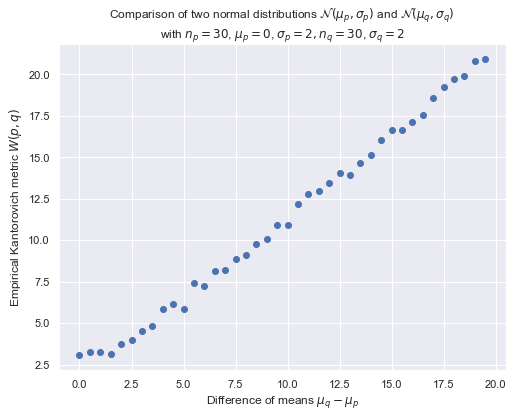

In [39]:
txt = 'Comparison of two normal distributions $\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'with $n_p = %1.0f$, $\mu_p = %1.0f$, $\sigma_p = %1.0f, $' % (n_p, mu_p, sigma_p)
txt = txt + '$n_q = %1.0f$, $\sigma_q = %1.0f$' % (n_q, sigma_q)
plt.title(txt)
plt.xlabel('Difference of means $\mu_q-\mu_p$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_mu, l_IPM_mu, 'o') ;
plt.savefig('W_diff_mu.png', dpi=120) # to save the figure

Can we say that the dependency of $W(p,q)$ to $\mu_q-\mu_p$ is linear? Yes. Indeed, we have:

In [40]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_mu), 1)
y = np.asarray(l_IPM_mu)

reg.fit(X, y)
print('The regression score is: \n', reg.score(X, y))
print('The regression coefficients are: \n', reg.coef_)
print('The regression intercept is: \n', reg.intercept_)

The regression score is: 
 0.9948106749894879
The regression coefficients are: 
 [[0.96993133]]
The regression intercept is: 
 [1.81937887]


### Influence of the difference of standard deviations $\sigma_q-\sigma_p$ on $W$

In [41]:
l_IPM_sigma = []
l_diff_sigma = []

mu_p = 0
sigma_p = 2
n_p = 30 # after several simulations, 30 seems enough
X_p = np.random.normal(mu_p, sigma_p, n_p)

mu_q = 0
n_q = n_p

l_abs = np.arange(0, 10, 0.25)
for sigma_q in l_abs:
    X_q = np.random.normal(mu_q, sigma_q, n_q)
    l_diff_sigma.append([sigma_q-sigma_p])
    l_IPM_sigma.append([kantorovich_metric(X_p, X_q)])

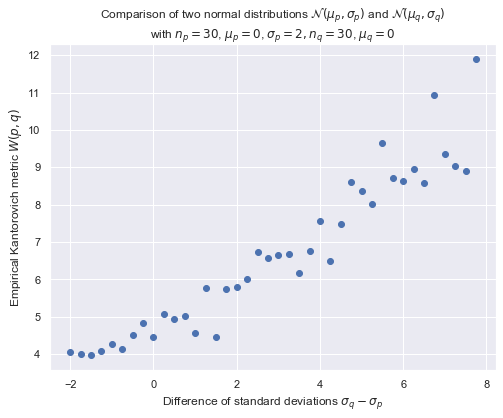

In [42]:
txt = 'Comparison of two normal distributions $\mathcal{N}(\mu_p, \sigma_p)$ and $\mathcal{N}(\mu_q, \sigma_q)$ \n'
txt = txt + 'with $n_p = %1.0f$, $\mu_p = %1.0f$, $\sigma_p = %1.0f, $' % (n_p, mu_p, sigma_p)
txt = txt + '$n_q = %1.0f$, $\mu_q = %1.0f$' % (n_q, mu_q)
plt.title(txt)
plt.xlabel('Difference of standard deviations $\sigma_q-\sigma_p$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_sigma, l_IPM_sigma, 'o') ;
plt.savefig('W_diff_sigma.png', dpi=120) # to save the figure

In [43]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_sigma), 1)
y = np.asarray(l_IPM_sigma)

reg.fit(X, y)
print('The regression score is: \n', reg.score(X, y))
print('The regression coefficients are: \n', reg.coef_)
print('The regression intercept is: \n', reg.intercept_)

The regression score is: 
 0.9059500327384539
The regression coefficients are: 
 [[0.6848077]]
The regression intercept is: 
 [4.69225948]


## Comparison of two uniform distributions

Here we consider two normal distributions $\mathbb{P} = \mathbb{U}\left([a, a+h]\right)$ and $\mathbb{Q} = \mathbb{U}\left([r, r+h]\right)$ where $h$ is the length of the intervals.

Note: $a$ is called the **interval start** of $[a, a+h]$.

In [44]:
l_IPM_unif = []
l_diff_unif = []

h = 2 # length of the intervals
a = 0
b = a+h
n_p = 30 # after several simulations, 30 seems enough
X_p = np.random.uniform(a, b, n_p)

n_q = n_p

l_abs = np.arange(0, 20, 0.5)
for r in l_abs:
    X_q = np.random.uniform(r, r+h, n_q)
    l_diff_unif.append([r-a])
    l_IPM_unif.append([kantorovich_metric(X_p, X_q)])

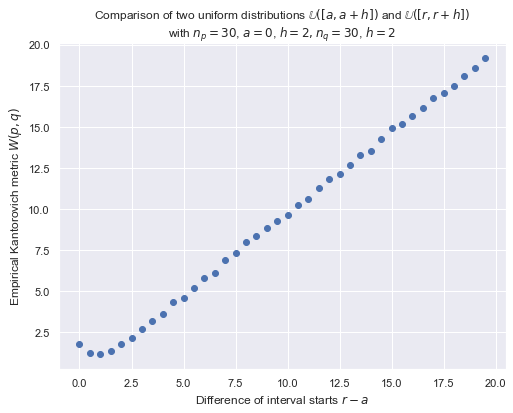

In [45]:
txt = 'Comparison of two uniform distributions $\mathbb{U}([a, a+h])$ and $\mathbb{U}([r, r+h])$ \n'
txt = txt + 'with $n_p = %1.0f$, $a = %1.0f$, $h = %1.0f, $' % (n_p, a, h)
txt = txt + '$n_q = %1.0f$, $h = %1.0f$' % (n_q, h)
plt.title(txt)
plt.xlabel('Difference of interval starts $r-a$')
plt.ylabel('Empirical Kantorovich metric $W(p, q)$')
plt.plot(l_diff_unif, l_IPM_unif, 'o') ;
plt.savefig('W_diff_unif.png', dpi=120) # to save the figure

In [46]:
reg = LinearRegression()
X = np.power(np.asarray(l_diff_unif), 1)
y = np.asarray(l_IPM_unif)

reg.fit(X, y)
print('The regression score is: \n', reg.score(X, y))
print('The regression coefficients are: \n', reg.coef_)
print('The regression intercept is: \n', reg.intercept_)

The regression score is: 
 0.9964314604926636
The regression coefficients are: 
 [[0.97021286]]
The regression intercept is: 
 [0.11602697]
